[A temperatura por ser aproximada pela lei de potência](http://pt.wikipedia.org/wiki/Lei_de_pot%C3%AAncia):

$t(z) = t_o, -\text{MLD} \le z < 0$

$t(z) = t_o az^{b}, z < -\text{MLD}$

In [1]:
import numpy as np


def temperature(to=25, a=115, b=-0.9, mld=200, maxdepth=4000):
    dz = 1
    z = np.arange(0, maxdepth + dz, dz)
    t_mld = [to] * len(z[:mld])
    t = to * a * z[mld:] ** b
    return np.r_[t_mld, t], z

  
mld = 200
t, z = temperature(mld=mld)

A salinidade será ajusta à temperatura através da sua relação TS para o Atlântico:

In [2]:
from netCDF4 import Dataset


nc = Dataset('woa01an.nc')
lon = nc.variables['WOA01_LONX'][:]
lat = nc.variables['WOA01_LATX'][:]
temp = nc.variables['WOA01_MEAN_TEMP'][:]
sal = nc.variables['WOA01_MEAN_PSAL'][:]

maskx = np.logical_and(lon < -5.5, lon > -45.5)
masky = np.logical_and(lat < 0, lat > -45)
lon = lon[maskx]
lat = lat[masky]

temp = temp[masky, ...][:, maskx, :].mean(axis=0).mean(axis=0)
sal = sal[masky, ...][:, maskx, :].mean(axis=0).mean(axis=0)

p = np.polyfit(temp, sal, 3)
S = np.polyval(p, t)
S[:mld+25] = S.max()

Finalmente a densidade é calculada usando ambos perfis:

In [3]:
import seawater as sw


dens = sw.dens0(S, t) - 1000

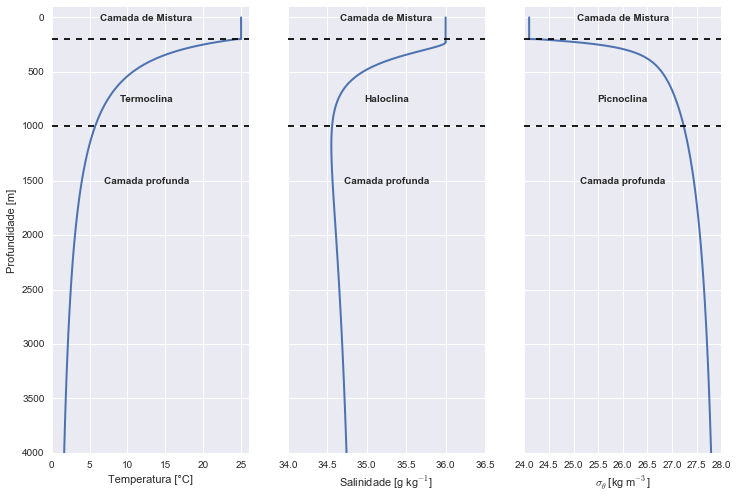

In [4]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt


fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True, figsize=(12, 8))

ax0.invert_yaxis()
kw = dict(colors='k', zorder=2)
kwp = dict(linewidth=2, zorder=1)
kwt = dict(va='center', ha='center', fontweight='semibold')

xmin, xmax = 0, 26
ax0.plot(t, z, **kwp)
ax0.set_xlim(xmin, xmax)
ax0.set_ylim(z.max(), -100)
ax0.set_xlabel(u'Temperatura [\u00B0C]')
ax0.set_ylabel('Profundidade [m]')

ax0.hlines(mld, xmin, xmax, linestyles='--', **kw)
ax0.hlines(1000, xmin, xmax, linestyles='--', **kw)

ax0.text(12.5, 0, 'Camada de Mistura', **kwt)
ax0.text(12.5, 750, 'Termoclina', **kwt)
ax0.text(12.5, 1500, 'Camada profunda', **kwt)

xmin, xmax = 34, 36.5
ax1.plot(S, z, **kwp)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(z.max(), -100)
ax1.set_xlabel(r'Salinidade [g kg$^{-1}$]')

ax1.hlines(mld, xmin, xmax, linestyles='--', **kw)
ax1.hlines(1000, xmin, xmax, linestyles='--', **kw)

ax1.text(35.25, 0, 'Camada de Mistura', **kwt)
ax1.text(35.25, 750, 'Haloclina', **kwt)
ax1.text(35.25, 1500, 'Camada profunda', **kwt)

xmin, xmax = 24, 28
ax2.plot(dens, z, **kwp)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(z.max(), -100)
ax2.set_xlabel(r'$\sigma_{\theta}$ [kg m$^{-3}$]')

ax2.hlines(mld, xmin, xmax, linestyles='--', **kw)
ax2.hlines(1000, xmin, xmax, linestyles='--', **kw)

ax2.text(26, 0, 'Camada de Mistura', **kwt)
ax2.text(26, 750, 'Picnoclina', **kwt)
ax2.text(26, 1500, 'Camada profunda', **kwt)
fig.savefig('profiles.pdf')

### TODO

[A salinidade será aproximada por uma exponecial dupla:](http://journals.ametsoc.org/doi/abs/10.1175/1520-0426%281992%29009%3C0812%3AOSHPFA%3E2.0.CO%3B2)

$S(z) = S_o, -\text{MLD} \le z < 0$

$ S(z) = S_b + (S_o - S_b)\{c \exp[(z+\text{MLD})/d_1] + (1-c)\exp[(z+\text{MLD})/d_2] \}, z < -\text{MLD}$

34.849977411112299

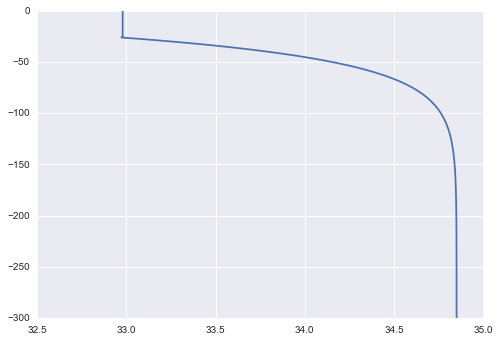

In [5]:
def salinity(So=32.98, Sb=34.85, d1=24.13, d2=24.23, c=0.42,
             mld=26.09, maxdepth=300):
    dz = 1
    z = np.arange(0, maxdepth + dz, dz)
    S_mld = [So] * len(z[:mld])
    exp1 = c * np.exp((-z + mld) / d1)
    exp2 = (1 - c) * np.exp((-z + mld) / d2)
    S = Sb + (So - Sb) * (exp1 + exp2)
    S[:mld] = S_mld
    return S, z

S, z = salinity()
plt.plot(S, -z)
S.max()